In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#40 TRAIN 

import os
import random

# Use the correct base directory and class names
base_dir = '/kaggle/input/brain-tumor-classification-mri'
classes = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

# Collect all image paths for each class from Training and Testing folders
class_images = {cls: [] for cls in classes}

for cls in classes:
    train_dir = os.path.join(base_dir, 'Training', cls)
    test_dir = os.path.join(base_dir, 'Testing', cls)
    if os.path.exists(train_dir):
        class_images[cls].extend([os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    if os.path.exists(test_dir):
        class_images[cls].extend([os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

# Use dedicated random generator for reproducibility
rng = random.Random(10)

# Split 40% train, 5% val, 55% test for each class
train_split = {cls: [] for cls in classes}
val_split = {cls: [] for cls in classes}
test_split = {cls: [] for cls in classes}

for cls in classes:
    imgs = class_images[cls]
    rng.shuffle(imgs)
    total = len(imgs)
    train_size = int(0.4 * total)  # Changed from 0.6 to 0.4
    val_size = int(0.05 * total)
    test_size = total - train_size - val_size
    train_split[cls] = imgs[:train_size]
    val_split[cls] = imgs[train_size:train_size+val_size]
    test_split[cls] = imgs[train_size+val_size:]

# Flatten into lists
all_train = []
all_val = []
all_test = []
for cls in classes:
    all_train.extend(train_split[cls])
    all_val.extend(val_split[cls])
    all_test.extend(test_split[cls])

# Shuffle the final lists with the same RNG for reproducibility
rng.shuffle(all_train)
rng.shuffle(all_val)
rng.shuffle(all_test)

# Print statistics
print("Total images:", len(all_train) + len(all_val) + len(all_test))
print("Total training images:", len(all_train))
print("Total validation images:", len(all_val))
print("Total testing images:", len(all_test))

Total images: 3264
Total training images: 1304
Total validation images: 162
Total testing images: 1798


In [3]:
def load_and_preprocess_images(image_paths, target_size=(150, 150)):
    """
    Load and preprocess images following melanoma study approach
    """
    images = []
    labels = []

    print(f"Loading {len(image_paths)} images...")

    for img_path in image_paths:
        try:
            # Extract label from path
            label = img_path.split('/')[-2]  # Get folder name as label

            # Load and resize image
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            images.append(img)
            labels.append(label)

        except Exception as e:
            print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

In [4]:
def preprocess_for_xgboost(images):
    """
    Preprocess images for XGBoost: Reshaping, Flattening, Casting, Normalization
    """
    # Flatten images: 150x150x3 = 67,500 features
    n_samples = images.shape[0]
    height, width, channels = images.shape[1], images.shape[2], images.shape[3]

    # Flatten and normalize
    X_flattened = images.reshape(n_samples, height * width * channels)
    X_normalized = X_flattened.astype('float32') / 255.0

    print(f"Preprocessed data shape: {X_normalized.shape}")
    print(f"Features: {X_normalized.shape[1]} (pixel-RGB values)")

    return X_normalized

In [5]:
# Step 1: Load and preprocess training data
X_train_images, y_train_labels = load_and_preprocess_images(all_train)
X_train = preprocess_for_xgboost(X_train_images)

# Step 2: Load and preprocess validation data
X_val_images, y_val_labels = load_and_preprocess_images(all_val)
X_val = preprocess_for_xgboost(X_val_images)

# Step 3: Load and preprocess test data
X_test_images, y_test_labels = load_and_preprocess_images(all_test)
X_test = preprocess_for_xgboost(X_test_images)

Loading 1304 images...
Preprocessed data shape: (1304, 67500)
Features: 67500 (pixel-RGB values)
Loading 162 images...
Preprocessed data shape: (162, 67500)
Features: 67500 (pixel-RGB values)
Loading 1798 images...
Preprocessed data shape: (1798, 67500)
Features: 67500 (pixel-RGB values)


In [6]:
# Step 4: Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_val = label_encoder.transform(y_val_labels)
y_test = label_encoder.transform(y_test_labels)

print(f"\nClass mapping: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")


Class mapping: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [7]:
# Step 5: XGBoost Model Configuration

xgb_params = {
    'objective': 'multi:softprob',  # Multi-class classification
    'num_class': len(label_encoder.classes_),
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'eval_metric': 'mlogloss',
    'verbosity': 1,
    'early_stopping_rounds': 20
}

In [8]:
# Initialize XGBoost classifier
xgb_model = XGBClassifier(**xgb_params)

# Train the model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-mlogloss:1.27795
[1]	validation_0-mlogloss:1.19410
[2]	validation_0-mlogloss:1.11789
[3]	validation_0-mlogloss:1.05776
[4]	validation_0-mlogloss:1.00044
[5]	validation_0-mlogloss:0.94865
[6]	validation_0-mlogloss:0.90411
[7]	validation_0-mlogloss:0.86084
[8]	validation_0-mlogloss:0.83032
[9]	validation_0-mlogloss:0.79477
[10]	validation_0-mlogloss:0.76370
[11]	validation_0-mlogloss:0.73821
[12]	validation_0-mlogloss:0.71175
[13]	validation_0-mlogloss:0.68720
[14]	validation_0-mlogloss:0.66166
[15]	validation_0-mlogloss:0.64039
[16]	validation_0-mlogloss:0.62749
[17]	validation_0-mlogloss:0.60971
[18]	validation_0-mlogloss:0.59002
[19]	validation_0-mlogloss:0.57846
[20]	validation_0-mlogloss:0.56636
[21]	validation_0-mlogloss:0.55235
[22]	validation_0-mlogloss:0.53960
[23]	validation_0-mlogloss:0.53191
[24]	validation_0-mlogloss:0.52249
[25]	validation_0-mlogloss:0.51569
[26]	validation_0-mlogloss:0.50949
[27]	validation_0-mlogloss:0.50070
[28]	validation_0-mlogloss:0.4

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_class=4, num_parallel_tree=None, ...)

In [9]:
# Step 6: Make Predictions
y_pred_train = xgb_model.predict(X_train)
y_pred_val = xgb_model.predict(X_val)
y_pred_test = xgb_model.predict(X_test)

In [10]:
# Step 7: Calculate Performance Metrics
train_accuracy = accuracy_score(y_train, y_pred_train)
val_accuracy = accuracy_score(y_val, y_pred_val)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"\nXGBOOST RESULTS")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy:.2%})")
print(f"Validation Accuracy: {val_accuracy:.4f} ({val_accuracy:.2%})")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy:.2%})")



XGBOOST RESULTS
Training Accuracy: 1.0000 (100.00%)
Validation Accuracy: 0.8457 (84.57%)
Test Accuracy: 0.8398 (83.98%)



CLASSIFICATION REPORT 
                  precision    recall  f1-score   support

    glioma_tumor       0.88      0.80      0.84       510
meningioma_tumor       0.80      0.79      0.79       517
        no_tumor       0.77      0.82      0.80       275
 pituitary_tumor       0.88      0.95      0.91       496

        accuracy                           0.84      1798
       macro avg       0.83      0.84      0.83      1798
    weighted avg       0.84      0.84      0.84      1798



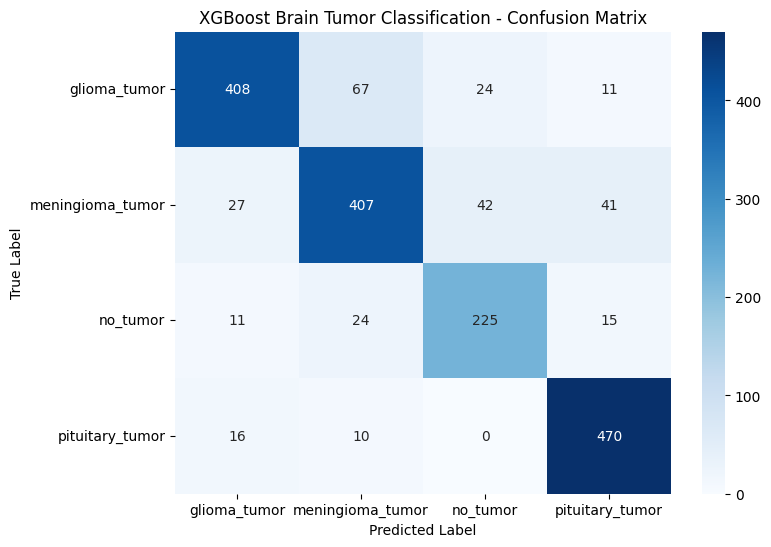

In [11]:
# Step 8: Detailed Classification Report
print(f"\nCLASSIFICATION REPORT ")
print(classification_report(y_test, y_pred_test,
                          target_names=label_encoder.classes_))

# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('XGBoost Brain Tumor Classification - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

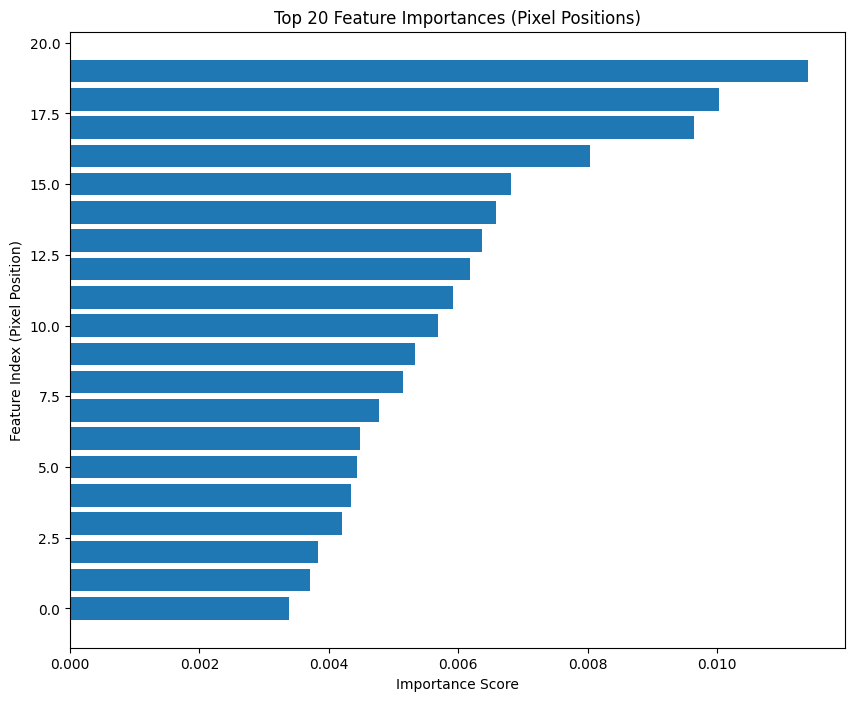


FINAL RESULTS
XGBoost Test Accuracy: 83.98%
Model trained on 1304 images
Validated on 162 images
Tested on 1798 images


In [12]:
# Step 10: Feature Importance (Top 20)
plt.figure(figsize=(10, 8))
feature_importance = xgb_model.feature_importances_
top_features = np.argsort(feature_importance)[-20:]

plt.barh(range(len(top_features)), feature_importance[top_features])
plt.title('Top 20 Feature Importances (Pixel Positions)')
plt.xlabel('Importance Score')
plt.ylabel('Feature Index (Pixel Position)')
plt.show()

print(f"\nFINAL RESULTS")
print(f"XGBoost Test Accuracy: {test_accuracy:.2%}")
print(f"Model trained on {len(all_train)} images")
print(f"Validated on {len(all_val)} images")
print(f"Tested on {len(all_test)} images")
